In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import sys #access to system parameters https://docs.python.org/3/library/sys.html
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv). Collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import matplotlib #collection of functions for scientific and publication-ready visualization
import scipy as sp #collection of functions for scientific computing and advanced mathematics
import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
import sklearn #collection of machine learning algorithms
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import random, time
#import time
import warnings
warnings.filterwarnings('ignore')
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv', 'gender_submission.csv']


In [2]:
#Common model algos
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

In [3]:
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics

In [4]:
#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

In [5]:
#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [6]:
raw_data = pd.read_csv('../input/train.csv')

In [7]:
test_data = pd.read_csv('../input/test.csv')

In [8]:
temp_data = raw_data.copy(deep = True)

In [9]:
clean_data = [temp_data, test_data]

In [10]:
for dataset in clean_data:
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)

In [11]:
drop_column = ['PassengerId', 'Cabin', 'Ticket']
temp_data.drop(drop_column, axis=1,inplace=True)

Consider creating new features that separate family size as purely binary values instead of whole numbers.

In [12]:
for dataset in clean_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4)
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5)

In [13]:
stat_min = 10
title_names = (temp_data['Title'].value_counts() < stat_min)
temp_data['Title'] = temp_data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

In [14]:
temp_data['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
FamilySize     418 non-null int64
IsAlone        418 non-null int64
Title          418 non-null object
FareBin        418 non-null category
AgeBin         418 non-null category
dtypes: category(2), float64(2), int64(6), object(6)
memory usage: 46.8+ KB


In [16]:
label = LabelEncoder()
#print(label)

In [17]:
temp_data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"
5,0,3,"Moran, Mr. James",male,28.0,0,0,8.4583,Q,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
6,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,51.8625,S,1,1,Mr,"(31.0, 512.329]","(48.0, 64.0]"
7,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,21.0750,S,5,0,Master,"(14.454, 31.0]","(-0.08, 16.0]"
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,3,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,2,0,Mrs,"(14.454, 31.0]","(-0.08, 16.0]"


In [18]:
print(temp_data['FareBin'].value_counts())
print(temp_data['AgeBin'].value_counts())
print(temp_data['IsAlone'].value_counts())
print(temp_data['Title'].value_counts())

(7.91, 14.454]     224
(-0.001, 7.91]     223
(31.0, 512.329]    222
(14.454, 31.0]     222
Name: FareBin, dtype: int64
(16.0, 32.0]     525
(32.0, 48.0]     186
(-0.08, 16.0]    100
(48.0, 64.0]      69
(64.0, 80.0]      11
Name: AgeBin, dtype: int64
1    537
0    354
Name: IsAlone, dtype: int64
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64


In [19]:
for dataset in clean_data:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    

In [20]:
Target = ['Survived']

In [21]:
temp_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
temp_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
temp_xy = Target + temp_x
print('Original X Y: ', temp_xy,'\n')

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 



In [22]:
temp_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
temp_xy_bin = Target + temp_x_bin
print('Bin X Y: ', temp_xy_bin,'\n')

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 



In [23]:
temp_data[temp_xy]

,Survived,Sex,Pclass,Embarked,Title,SibSp,Parch,Age,Fare,FamilySize,IsAlone
0,0,male,3,S,Mr,1,0,22.0,7.2500,2,0
1,1,female,1,C,Mrs,1,0,38.0,71.2833,2,0
2,1,female,3,S,Miss,0,0,26.0,7.9250,1,1
3,1,female,1,S,Mrs,1,0,35.0,53.1000,2,0
4,0,male,3,S,Mr,0,0,35.0,8.0500,1,1
5,0,male,3,Q,Mr,0,0,28.0,8.4583,1,1
6,0,male,1,S,Mr,0,0,54.0,51.8625,1,1
7,0,male,3,S,Master,3,1,2.0,21.0750,5,0
8,1,female,3,S,Mrs,0,2,27.0,11.1333,3,0
9,1,female,2,C,Mrs,1,0,14.0,30.0708,2,0


In [24]:
temp_dummy = pd.get_dummies(temp_data[temp_x])
temp_x_dummy = temp_dummy.columns.tolist()
temp_xy_dummy = Target + temp_x_dummy
print('Dummy X Y: ', temp_xy_dummy, '\n')

temp_dummy.head()

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


In [25]:
print (temp_data.isna().sum())
print ('--'*20)
print (test_data.isna().sum())
print ('--'*20)

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------------------------------------
PassengerId        0
Pclass             0
Name               0
Sex                0
Age                0
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            327
Embarked           0
FamilySize         0
IsAlone            0
Title              0
FareBin            0
AgeBin             0
Sex_Code           0
Embarked_Code      0
Title_Code         0
AgeBin_Code        0
FareBin_Code       0
dtype: int64
----------------------------------------


In [26]:
raw_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Andersson, Miss. Erna Alexandra",male,NaN,NaN,NaN,347082,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [27]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(temp_data[temp_x_calc], temp_data[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(temp_data[temp_x_bin], temp_data[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train_y_dummy, test_y_dummy = model_selection.train_test_split(temp_dummy[temp_x_dummy], temp_data[Target], random_state = 0)

print("Temp Shape: {}".format(temp_data.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Temp Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


**Done Cleaning!**

In [28]:
for feature in temp_x:
    if temp_data[feature].dtype != 'float64':
        print ('Survival Correlation by: ',feature)
        print (temp_data[[feature, Target[0]]].groupby(feature, as_index=False).mean())
        print('--'*20, '\n')

Survival Correlation by:  Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------------------------------------- 

Survival Correlation by:  Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------------------------------------- 

Survival Correlation by:  Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------------------------------------- 

Survival Correlation by:  Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------------------------------------- 

Survival Correlation by:  SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------------------------------------- 

Survival Correlation by:  Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000


In [29]:
#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(temp_data['Title'],temp_data[Target[0]]))

Survived    0    1
Title             
Master     17   23
Misc       15   12
Miss       55  127
Mr        436   81
Mrs        26   99


In [30]:
temp_data[temp_data['Survived'] == 1]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,4,2,3
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,2,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,2,4,2,3
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,11.1333,S,3,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]",0,2,4,1,1
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,30.0708,C,2,0,Mrs,"(14.454, 31.0]","(-0.08, 16.0]",0,0,4,0,2
10,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,16.7000,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]",0,2,2,0,2
11,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,26.5500,S,1,1,Miss,"(14.454, 31.0]","(48.0, 64.0]",0,2,2,3,2
15,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.00,0,0,16.0000,S,1,1,Mrs,"(14.454, 31.0]","(48.0, 64.0]",0,2,4,3,2
17,1,2,"Williams, Mr. Charles Eugene",male,28.00,0,0,13.0000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]",1,2,3,1,1
19,1,3,"Masselmani, Mrs. Fatima",female,28.00,0,0,7.2250,C,1,1,Mrs,"(-0.001, 7.91]","(16.0, 32.0]",0,0,4,1,0


In [31]:
temp_data[temp_data['Survived']==1]['Title'].value_counts()/temp_data['Title'].value_counts() * 100

Master    57.500000
Misc      44.444444
Miss      69.780220
Mr        15.667311
Mrs       79.200000
Name: Title, dtype: float64

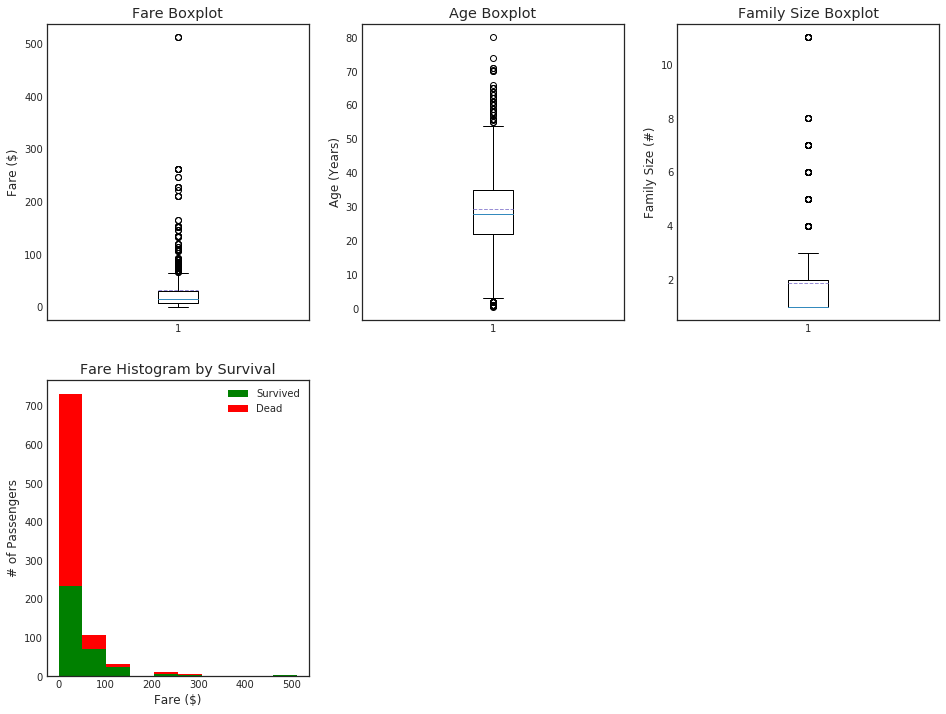

In [32]:
#plt.figure(figsize=[16,12])
plt.figure(figsize=[16,12])
#plt.subplot(231)
plt.subplot(231)
#plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.boxplot(x=temp_data['Fare'], showmeans=True, meanline=True)
#plt.title('Fare Boxplot')
plt.title('Fare Boxplot')
#plt.ylabel('Fare ($)')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(temp_data['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

#plt.subplot(233)
plt.subplot(233)
#plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.boxplot(temp_data['FamilySize'], showmeans=True, meanline=True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

#plt.subplot(234)
plt.subplot(234)
#plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.hist(x = [temp_data[temp_data['Survived']==1]['Fare'],temp_data[temp_data['Survived']==0]['Fare']],
        stacked=True, color =['g', 'r'], label=['Survived', 'Dead'])
#plt.title('Fare Histogram by Survival')
plt.title('Fare Histogram by Survival')
#plt.xlabel('Fare ($)')
plt.xlabel('Fare ($)')
#plt.ylabel('# of Passengers')
plt.ylabel('# of Passengers')
#plt.legend()
plt.legend()

#plt.subplot(235)
#plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Age Histogram by Survival')
#plt.xlabel('Age (Years)')
#plt.ylabel('# of Passengers')
#plt.legend()

#plt.subplot(236)
#plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
#         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
#plt.title('Family Size Histogram by Survival')
#plt.xlabel('Family Size (#)')
#plt.ylabel('# of Passengers')
#plt.legend()